In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [2]:
DATA_DIR = Path('data/')
PRIOR_DATA_DIR = Path('data/Trips_2018/')
data_path = PRIOR_DATA_DIR / 'Trips_2018.csv'

In [3]:
data = pd.read_csv(data_path)

In [4]:
data.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


In [5]:
data.shape

(17548339, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17548339 entries, 0 to 17548338
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   tripduration             int64  
 2   starttime                object 
 3   stoptime                 object 
 4   start_station_id         float64
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           float64
 8   end_station_latitude     float64
 9   end_station_longitude    float64
 10  bikeid                   int64  
 11  usertype                 object 
 12  birth_year               int64  
 13  gender                   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.8+ GB


In [7]:
data.isna().sum()

Unnamed: 0                    0
tripduration                  0
starttime                     0
stoptime                      0
start_station_id           2497
start_station_latitude        0
start_station_longitude       0
end_station_id             2497
end_station_latitude          0
end_station_longitude         0
bikeid                        0
usertype                      0
birth_year                    0
gender                        0
dtype: int64

Drop Unnamed (id Collumn)

In [8]:
data = data.drop('Unnamed: 0',axis=1)

Configure datetime to our date data

In [9]:
data['start_time'] = pd.to_datetime(data['starttime'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stoptime'], format="%Y-%m-%d %H:%M:%S.%f")

Drop old date collumns

In [10]:
data = data.drop('starttime',axis=1)
data = data.drop('stoptime',axis=1)

Remove Tuples that have Missing Values

In [11]:
before = len(data)
data = data.dropna()
after = len(data)

print(f"Before: {before}\nAfter: {after}\nRemoved: {before - after}")

Before: 17548339
After: 17545842
Removed: 2497


Ensure latitude/longitude values fall within New York City bounds.


In [12]:
before = len(data)

lat_min, lat_max = 40.45, 40.92
lon_min, lon_max = -74.30, -73.65

data = data[
    data["start_station_latitude"].between(lat_min, lat_max)
    & data["start_station_longitude"].between(lon_min, lon_max)
    & data["end_station_latitude"].between(lat_min, lat_max)
    & data["end_station_longitude"].between(lon_min, lon_max)
]

after = len(data)

print("Rows before filtering:", before)
print("Rows after filtering:", after)
print("Rows removed:", before - after)


Rows before filtering: 17545842
Rows after filtering: 17545760
Rows removed: 82


In [13]:
data["usertype"].unique()

array(['Subscriber', 'Customer'], dtype=object)

In [14]:
data["usertype"] = data["usertype"].map({
    "Subscriber": 1,
    "Customer": 0
})

In [15]:
before = len(data)
data = data.drop_duplicates()
after = len(data)

print(f"Duplicates removed: {before - after}")


Duplicates removed: 0


Check if start time is after end time

In [16]:
mask = data["stop_time"] < data["start_time"]

print("Number of rows with stop_time < start_time:", mask.sum())

Number of rows with stop_time < start_time: 0


In [17]:
data['tripduration_min'] = (data['tripduration'] / 60).round(2)

In [18]:
data["duration_min_from_time"] = ((data["stop_time"] - data["start_time"]).dt.total_seconds()/60).round(2)

In [19]:
diff = (data["tripduration_min"] - data["duration_min_from_time"]).abs()

In [20]:
n_over_5 = (diff > 5).sum()
print("Rows with difference > 5 minutes:", n_over_5)

Rows with difference > 5 minutes: 151


In [21]:
mask = diff > 5
rows_over_5 = data[mask]

print("Number of rows with diff > 5:", len(rows_over_5))
rows_over_5

Number of rows with diff > 5: 151


,tripduration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,start_time,stop_time,tripduration_min,duration_min_from_time
369257,11138807,501.0,40.744219,-73.971212,3245.0,40.716444,-73.982331,15336,0,1969,0,2018-01-27 15:37:18.019,2018-06-05 14:44:05.591,185646.78,185706.79
476336,19510049,3082.0,40.711674,-73.951413,144.0,40.698399,-73.980689,30503,0,1953,1,2018-01-22 18:20:27.512,2018-09-05 14:47:56.868,325167.48,325227.49
656565,8121483,3440.0,40.692418,-73.989495,3432.0,40.669060,-73.994637,25788,1,1962,1,2018-01-14 11:53:04.469,2018-04-18 12:51:08.162,135358.05,135418.06
687964,11699746,3537.0,40.680974,-73.971010,3245.0,40.716444,-73.982331,19957,0,1969,0,2018-01-28 03:51:28.614,2018-06-12 14:47:15.583,194995.77,195055.78
735287,3615030,151.0,40.722104,-73.997249,3071.0,40.705381,-73.949765,32337,0,1969,0,2018-02-18 16:12:16.708,2018-04-01 13:22:46.816,60250.50,60310.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15455425,47057,405.0,40.739323,-74.008119,3660.0,40.741022,-74.001385,19606,0,1969,0,2018-11-03 23:09:19.401,2018-11-04 11:13:36.983,784.28,724.29
15455874,10197,347.0,40.728846,-74.008591,347.0,40.728846,-74.008591,21335,0,1969,0,2018-11-03 23:36:47.226,2018-11-04 01:26:44.537,169.95,109.96
15456532,5978,482.0,40.739355,-73.999318,526.0,40.747659,-73.984907,29173,0,1993,1,2018-11-04 00:24:57.096,2018-11-04 01:04:35.574,99.63,39.64
15456671,5299,312.0,40.722055,-73.989111,312.0,40.722055,-73.989111,33268,1,1999,1,2018-11-04 00:38:33.031,2018-11-04 01:06:52.148,88.32,28.32


In [22]:
before = len(data)
data = data[diff<=5]
after = len(data)
print(f"Rows removed due to bad durations: {before - after}")

Rows removed due to bad durations: 151


In [23]:
data = data.drop(columns=["duration_min_from_time", "tripduration"])

In [24]:
current_year = data["start_time"].dt.year

data["age"] = current_year - data["birth_year"]

before = len(data)
data = data[(data["age"] >= 10) & (data["age"] <= 90)]
after = len(data)

print(f"Rows removed due to unrealistic age: {before - after}")

Rows removed due to unrealistic age: 13452


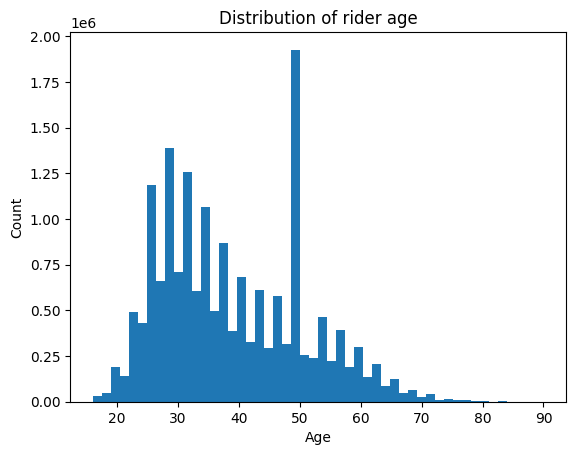

In [25]:
plt.hist(data["age"], bins=50)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of rider age")
plt.show()


In [26]:
n = (data['age'] > 90).sum()
print("Number of rows with age > 90:", n)

Number of rows with age > 90: 0


In [27]:
data = data.drop(columns=["birth_year"])

In [28]:
data.head()

,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26


In [29]:
mask = (data['tripduration_min'] >= 1) & (data['tripduration_min'] <= 120)
print("Rows before:", len(data))
print("Rows kept:", mask.sum())
print("Rows removed:", len(data) - mask.sum())

data = data[mask]


Rows before: 17532157
Rows kept: 17480683
Rows removed: 51474


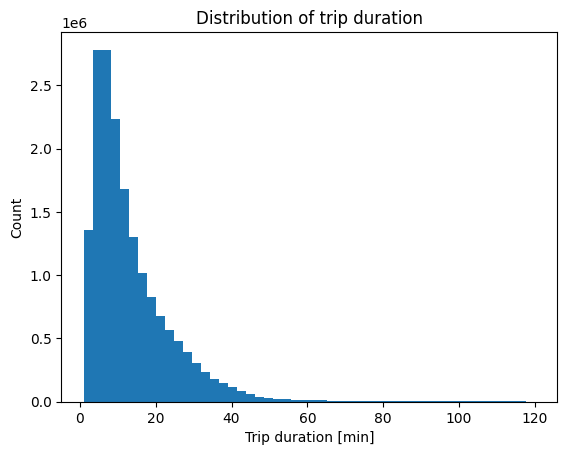

In [30]:
import matplotlib.pyplot as plt

plt.hist(data["tripduration_min"], bins=50)
plt.xlabel("Trip duration [min]")
plt.ylabel("Count")
plt.title("Distribution of trip duration")
plt.show()


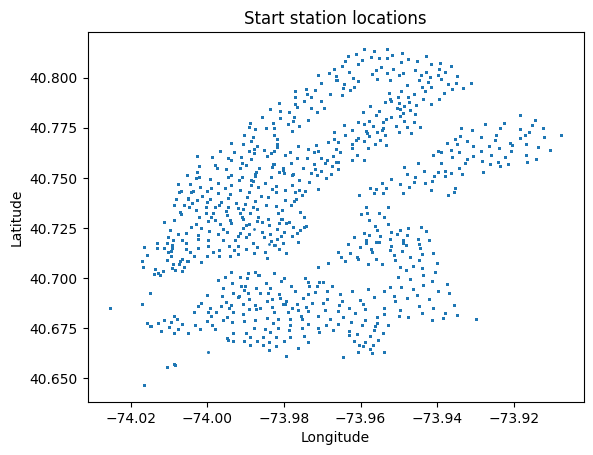

In [31]:
plt.scatter(data["start_station_longitude"], data["start_station_latitude"], s=1)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Start station locations")
plt.show()


In [32]:
data["gender"].unique()

array([1, 0, 2], dtype=int64)

Gender column is problematic, three types and don't know which column is male/female

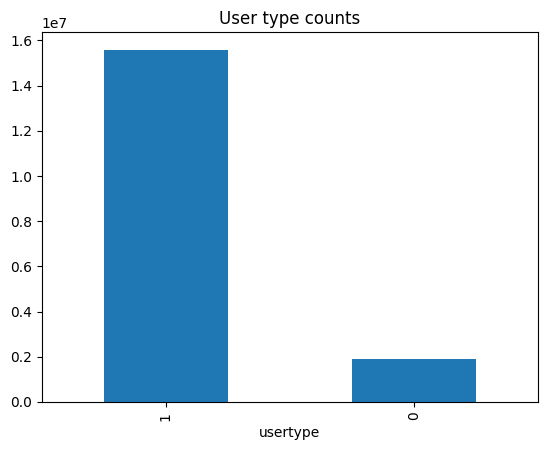

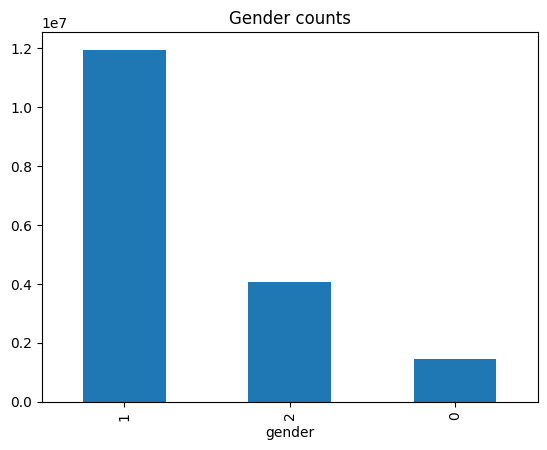

In [33]:
data["usertype"].value_counts().plot(kind="bar")
plt.title("User type counts")
plt.show()

data["gender"].value_counts().plot(kind="bar")
plt.title("Gender counts")
plt.show()


In [34]:
data.to_csv(DATA_DIR/ 'Trips_2018_clean.csv', index=False)